In [1]:
from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# load all metadata

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marcos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/marcos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
#Cargamos los datos
data = pd.read_csv('justice.csv')
X = data['facts']
Y = data['first_party_winner']

In [33]:
#Pasa las etiquetas escritas a valores numéricos
def getLabels(Y):
    names = []
    newY =  []
    for i in Y:
        if i not in names:
            names.append(i)
        newY.append(names.index(i))
    return newY, names

In [34]:
#Pasamos la etiquetas de FirstPartyWinner a valores numéricos
y_labels, y_names = getLabels(Y)

In [16]:
#Elimina signos de puntuación y todo a minúsculas
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(X))

In [18]:
#Eliminamos las stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

In [19]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [38]:
#Lematizamos
def lemmatization(texts):
    texts_out = []
    for text in texts:
        lemText = []
        for sent in text:
            stemmed = ps.stem(sent)
            lemText.append(lem.lemmatize(stemmed))
        texts_out.append(lemText)
    return texts_out

data_lemmatized = lemmatization(data_words_nostops)

In [39]:
#Crea un modelo con n numero de Topics en relación a los datos administrados
#Utilizamos 202 porque hemos visto en el proyecto que son los que mejor Accuracy nos proporcionan
def get_topicModeling(data, n_topics):
    #Topic modeling
    id2word = corpora.Dictionary(data)
    texts = data
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=100, passes=10, eval_every=None)
    count = 0
    topics=[]
    for i in lda_model.print_topics():
        topics.append(i)
        count += 1
    return lda_model,corpus,topics

model, corpus, topics = get_topicModeling(data_lemmatized,202)

In [51]:
def get_vectorized(model, corpus):
    n_topics = model.num_topics
    vectorized = []
    #Recorrer los documentos
    for i in model[corpus]:
        #Inicializar index como lista de ceros, de longitud 'n_topics'
        index = [0]*n_topics
        #Recorrer cada palabra de cada documento
        for n in i:
            #En index[8] guardamos la informacion del tópico 8
            index[n[0]] = n[1]
        vectorized.append(index)
    vectorized = pd.DataFrame(vectorized)
    #Filas documentos (facts)
    #Columnas topics
    return vectorized


vectorized = get_vectorized(model,corpus)

In [74]:
from sklearn.model_selection import train_test_split
def train_test(test):
    return train_test_split(vectorized,y_labels,test_size=test, random_state=1)
#Probamos con 30% de test y 70% de train
X_train, X_test, Y_train, Y_test = train_test(0.3)

In [64]:
##KNN Y TREE

In [64]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

def decision_tree(md):
    clf = DecisionTreeClassifier(max_depth=md)
    clf = clf.fit(vectorized,y_labels)
    
    #Y_pred = clf.predict(X_test)
    #probas = clf.predict_proba(X_test)
    ##print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
    return clf
#Probamos con máxima repetición 3
clf = decision_tree(3)

[Text(0.5, 0.875, '25 <= 0.075\ngini = 0.459\nsamples = 3303\nvalue = [2140, 1148, 15]\nclass = True'),
 Text(0.25, 0.625, '19 <= 0.041\ngini = 0.467\nsamples = 3016\nvalue = [1917, 1084, 15]\nclass = True'),
 Text(0.125, 0.375, '2 <= 0.034\ngini = 0.471\nsamples = 2865\nvalue = [1800, 1050, 15]\nclass = True'),
 Text(0.0625, 0.125, 'gini = 0.469\nsamples = 2830\nvalue = [1788, 1027, 15]\nclass = True'),
 Text(0.1875, 0.125, 'gini = 0.451\nsamples = 35\nvalue = [12, 23, 0]\nclass = False'),
 Text(0.375, 0.375, '48 <= 0.08\ngini = 0.349\nsamples = 151\nvalue = [117, 34, 0]\nclass = True'),
 Text(0.3125, 0.125, 'gini = 0.304\nsamples = 139\nvalue = [113, 26, 0]\nclass = True'),
 Text(0.4375, 0.125, 'gini = 0.444\nsamples = 12\nvalue = [4, 8, 0]\nclass = False'),
 Text(0.75, 0.625, '191 <= 0.015\ngini = 0.347\nsamples = 287\nvalue = [223, 64, 0]\nclass = True'),
 Text(0.625, 0.375, '39 <= 0.016\ngini = 0.325\nsamples = 274\nvalue = [218, 56, 0]\nclass = True'),
 Text(0.5625, 0.125, 'gini 

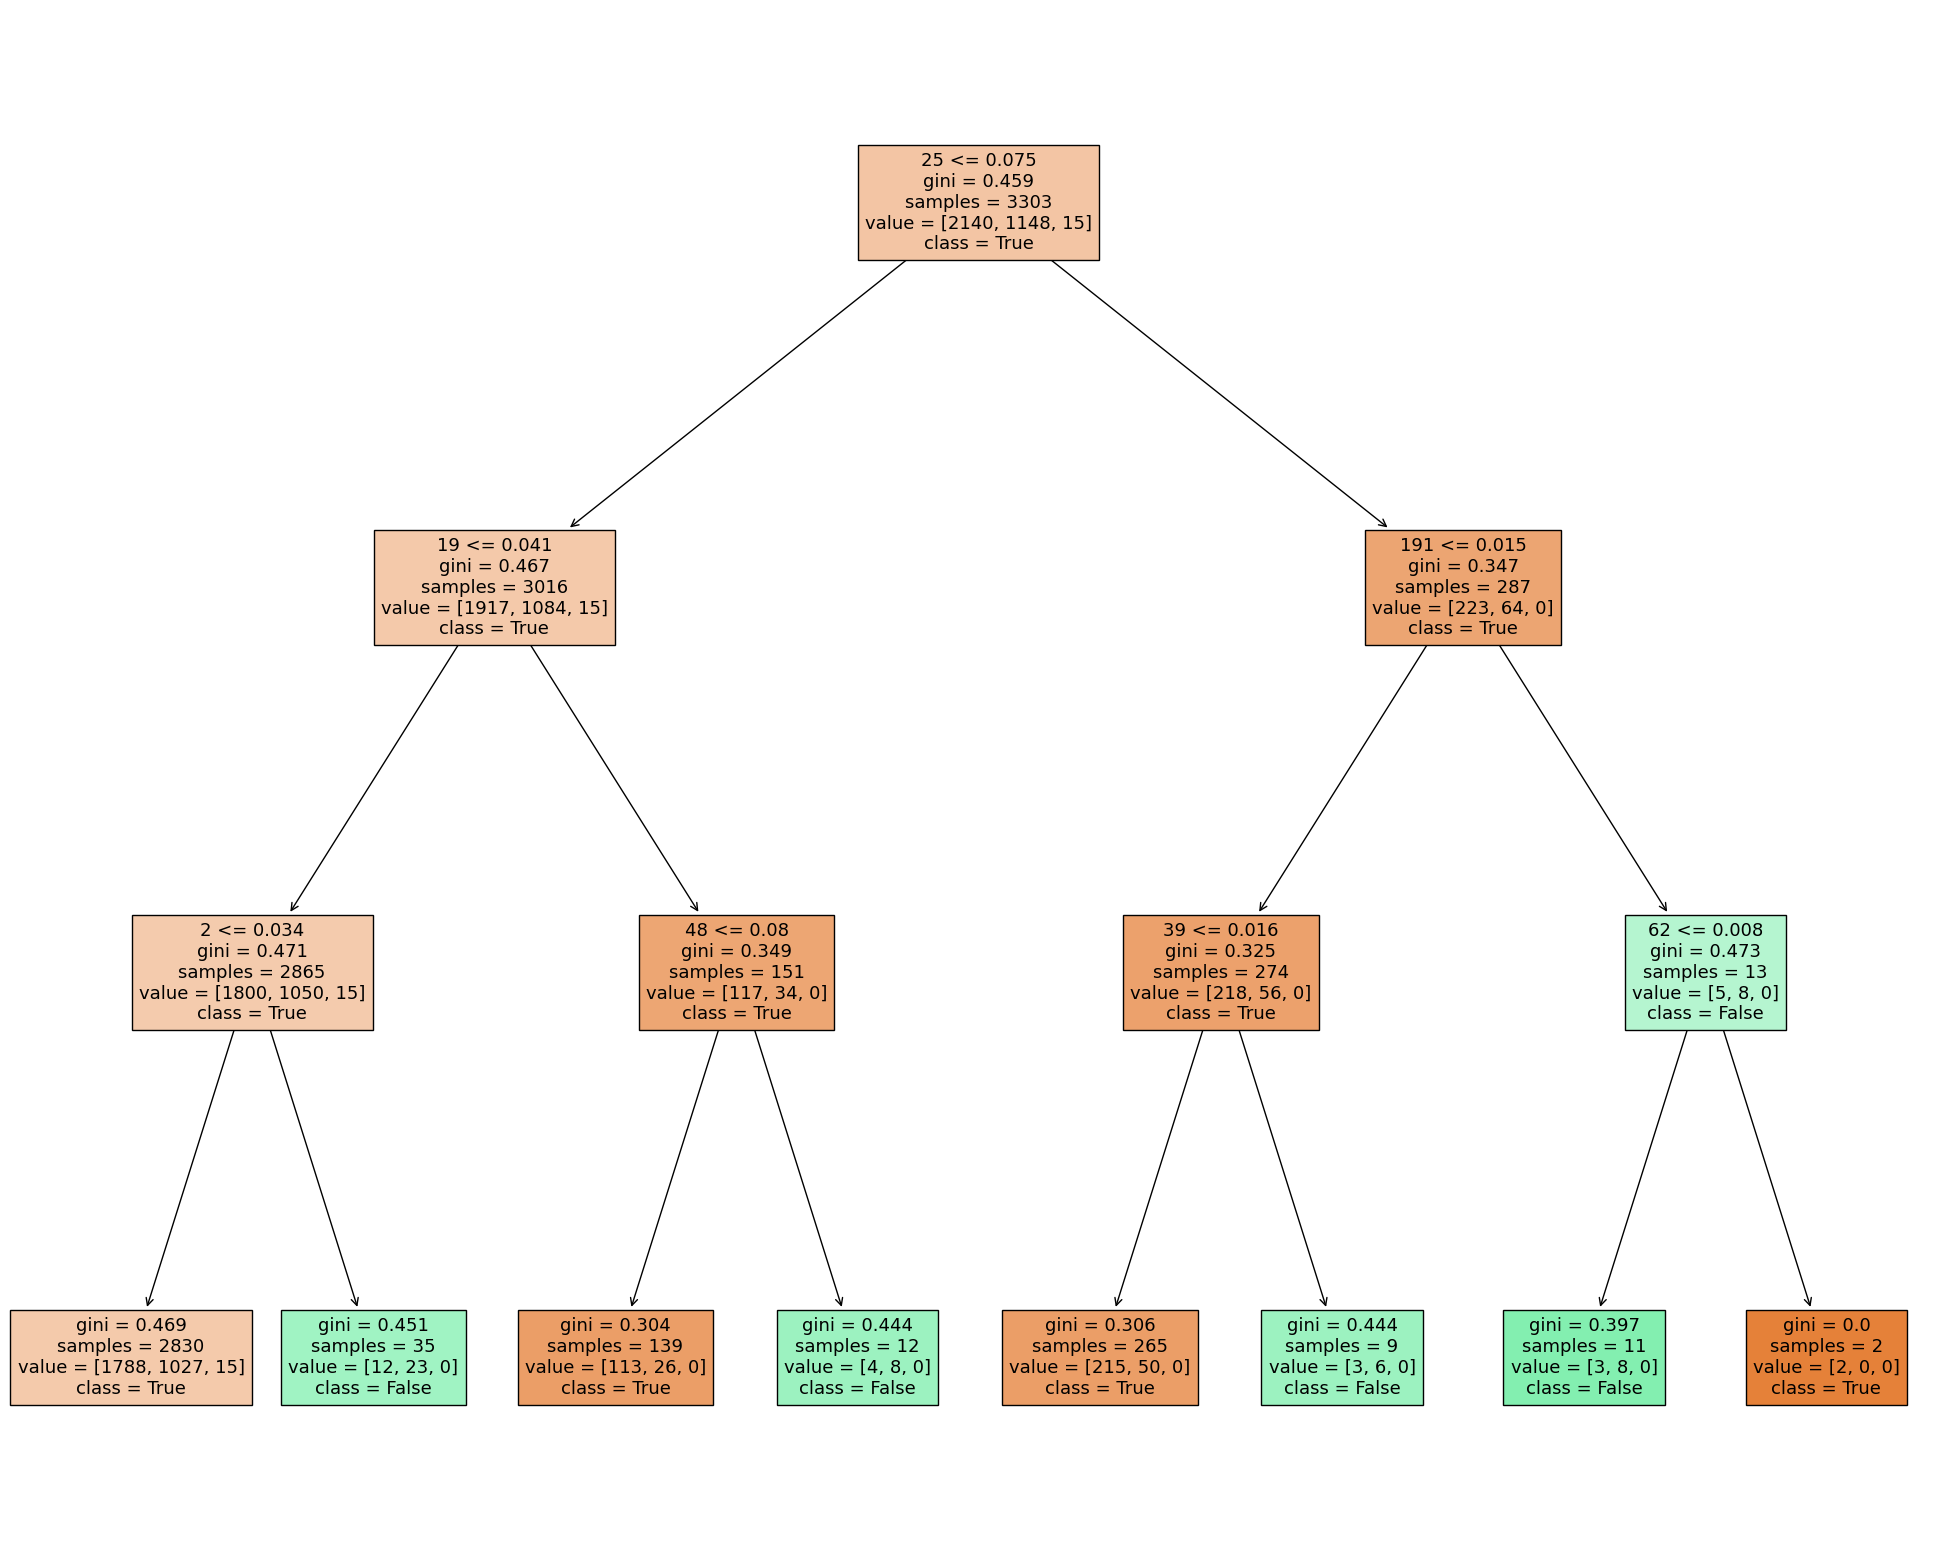

In [72]:
from matplotlib import pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf,filled=True,class_names=["True","False","Nan"],feature_names=range(0,202))

In [65]:
#KNN
def knn(k,K,d,D):
    indice = 1
    F1 = []
    total = []
    weigths = ['uniform','distance']
    for k_value in range(int(k),int(K) + 1, 2):
        for d_value in range(int(d),int(D) + 1):
            for weigth in weigths:
                clf = KNeighborsClassifier(n_neighbors=k_value,
                                           weights=weight,
                                           algorithm='auto',
                                           leaf_size=30,
                                           p=d_value)
                clf.class_weigth = "balanced"
                clf.fit(X_train,Y_train)
                
                Y_pred = clf.predict(X_test)
                probas = clf.predict_proba(X_test)
                
                info = [
                    "Caso " + str(indice) + " : " + "k :" + str(k_value) + ", " + "d : " + str(
                        d_value) + ", " + "weight : " + str(weight) + " ---> ",
                    f1_score(Y_test, Y_pred, average=None),
                    classification_report(Y_test, Y_pred),
                    confusion_matrix(Y_test, Y_pred, y_names)
                ]
                indice += 1
                
                F1.append(f1_score(y_test, predictions, average=None))
                total.append([info[0], f1_score(y_test, predictions, average=None), info[2]])
                file = open('knn.csv', 'a')
                file.write("\n" + str(info[0]) + str(info[1]) + "\n" + str(info[2]) + "\n")
    F1_max = -1
    for maximo in F1:
        if maximo[0] > F1_max:
            F1_max = maximo[0]

    for infor in total:
        f1 = infor[1]
        if f1[0] == F1_max:
            file = open('mejor_knn.csv', 'a')
            file.write("\n" + str(infor[0]) + str(f1[0]) + "\n" + str(infor[2]) + "\n")
##Probamos con 
#knn()

In [ ]:
##NO HE SEGUIDO

In [ ]:
#Comparar dimensiones antes y después de hacer el pca
from sklearn.decomposition import  PCA

#Redimensiona los datos introducidos a las dimensiones pedidas
#Utilizamos 2 para el número de PCA porque hemos visto en el proyecto que obtenemos gran silueta
def get_PCA(data, nPCA):
    print("Before:", data.shape)
    #pca = PCA(n_components='mle', svd_solver='full')
    pca = PCA(n_components=nPCA)
    pca.fit(data)
    data_PCA= pca.transform(data)
    print("After:", data_PCA.shape)
    return data_PCA, pca

data_PCA, pca = get_PCA(vectorized,2)

In [ ]:
#Devuelve la precision a partir de una matriz de confusión
def get_accuracy_unorder(cm):
    total = 0
    correct = 0
    row = 0
    for i in cm:
        column = 0
        for n in i:
            total += n
            if column == row and column < len(cm[0]):
                correct += n
            column += 1
        row += 1
    return total, correct , correct/total

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Devuelve la matriz de confusion
def get_cm(Y_labels, predictions, names, visual = True):
    # El atributo generado por K-means es int, hay que pasarlos a string
    to_string = lambda x : str(x)
    # Obtener matriz de confusión Class to clustering eval
    cm = confusion_matrix(predictions, Y_labels)
    #Borrar la columnas vacias
    columns = cm.any(axis=0)
    delete = []
    for i in range(len(columns)):
        if not columns[i]:
            delete.append(i)
    cm = np.delete(cm, delete, axis=1)


    ylabels=[None for i in range(len(cm))]
    ymax=[0 for i in range(len(cm))]
    cm_copy = cm.copy()
    for i in range(19):
        cont=0
        for i in cm_copy:
            if ylabels[cont] == None:
                if i.argmax() in ylabels:
                    x=ymax[i.argmax()]
                    y=i.max()
                    if y > x[1] :
                        ylabels[x[0]] = None
                        ylabels[cont] = i.argmax()
                        ymax[i.argmax()]=(cont,i.max())
                        cm_copy[x[0]][i.argmax()]=0
                    else:
                        cm_copy[cont][i.argmax()]=0
                else:
                    ylabels[cont] = i.argmax()
                    ymax[i.argmax()]=(cont,i.max())
            cont=cont+1

    cm_new = [[] for i in range(len(cm))]
    cont = 0
    used = [i for i in range(len(cm))]
    cont_down = 0
    for i in ylabels:
        if i is not None:
            cm_new[i] = cm[cont].tolist()
            used.remove(cont)
        elif cont_down < len(cm)- len(cm[0]):
            cm_new[len(cm)-cont_down - 1] = cm[cont].tolist()
            used.remove(cont)
            cont_down +=1
        cont += 1

    for i in range(len(cm_new)):
        if not cm_new[i]:
            cm_new[i] = cm[used[0]]
            ylabels[used[0]] = i
            used.remove(used[0])

    new_ylabels = [None] * len(ylabels)
    for i in range(len(ylabels)):
        if ylabels[i] is not None:
            new_ylabels[ylabels[i]] = names[ylabels[i]]
    ylabels = new_ylabels

    if visual:
        # Mapa de calor a partir de la matriz de confusion
        ax = sns.heatmap(cm_new, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=ylabels)
        print(get_accuracy_unorder(cm_new))

    return cm_new

cm = get_cm(y1_labels, k_labels, y1_names, True)
#El valor real es el de abajo

In [ ]:
from sklearn.metrics import accuracy_score
def getAll(range_topics, range_PCA, range_clusters, data):
    scores = []
    for t in range_topics:
        model,corpus,topics = get_topicModeling(data, t)
        vectorized = get_vectorized(model,corpus)
        for p in [x for x in range_PCA if x <= t]:
            data_PCA,pca = get_PCA(vectorized,p)
            list_of_clusters,tree = hierarchical_clustering(data_PCA)
            for c in range_clusters:
                k_labels,dist,k_clusters = get_nClusters(list_of_clusters,c)
                sj = silhouette_score(data_PCA,k_labels)
                cm = get_cm(y1_labels, k_labels, y1_names, False)
                acc1 = get_accuracy_unorder(cm)[2]
                cm = get_cm(y2_labels, k_labels, y2_names, False)
                acc2 = get_accuracy_unorder(cm)[2]
                scores.append([c,dist,p,t,sj,acc1,acc2])
                df_scores = pd.DataFrame(scores)
    df_scores = df_scores.set_axis(["nClusters", "dist", "PCA", "nTopics", "silhouetteValue", "Acc_FirstPartyWinner", "Acc_IssueArea"], axis="columns")
    df_scores.to_csv("scores3.csv", encoding="utf-8", sep=',',index=False, header=True)
    return scores

range_topics = [i for i in range(200,401,50)]
#scores = getAll(range_topics, range(2,403,100), range(2,20,1), data_lemmatized)

In [ ]:
def get_plot_scores(csv, x_label, y_label, func):
    df_scores = pd.read_csv(csv)
    x_index = list(df_scores.columns.values).index(x_label)
    y_index = list(df_scores.columns.values).index(y_label)
    nTopics = []
    nTopicsScore = []
    for d in df_scores.values:
        if d[x_index] in nTopics:
            nTopicsScore[nTopics.index(d[x_index])].append(d[y_index])
        else:
            nTopics.append(d[x_index])
            nTopicsScore.append([d[y_index]])

    for s in range(len(nTopicsScore)):
        nTopicsScore[s] = func(nTopicsScore[s])
    df = pd.DataFrame({
          'x_axis': nTopics,
          'y_axis': nTopicsScore
      })
    df.sort_values('x_axis', ignore_index=True, inplace=True)
    plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')
    plt.show()

In [ ]:
#Graficos del número de Topicos, PCA, y número de Clusters, en relación con la precisión en FirstPartyWinner
get_plot_scores("scores1.csv","nTopics","Acc_FirstPartyWinner", np.mean)
get_plot_scores("scores1.csv", "PCA", "Acc_FirstPartyWinner", np.mean)
get_plot_scores("scores1.csv","nClusters","Acc_FirstPartyWinner", np.mean)

In [ ]:
#Graficos del número de Topicos, PCA, y número de Clusters, en relación con el valor de la silhouette
get_plot_scores("scores1.csv","nTopics","silhouetteValue", np.mean)
get_plot_scores("scores1.csv", "PCA", "silhouetteValue", np.mean)
get_plot_scores("scores1.csv","nClusters","silhouetteValue", np.mean)

In [ ]:
import pickle as pk

def save_model(data, nTopics, nPCA, nClusters, trainLabels, trainNames, csvName):
    model,corpus, topics = get_topicModeling(data,nTopics)
    pk.dump(model, open("lda_" + csvName + ".pkl","wb"))
    vectorized = get_vectorized(model,corpus)
    data_PCA, pca = get_PCA(vectorized,nPCA)

    pk.dump(pca, open("pca_" + csvName + ".pkl","wb"))
    list_of_clusters, tree = hierarchical_clustering(data_PCA)
    labels, dist, clusters = get_nClusters(list_of_clusters, nClusters)
    cm = get_cm(trainLabels, labels, trainNames)
    get_silhouette(data_PCA,list_of_clusters,[nClusters])
    plot_dendrogram(tree,labels,dist)

    pd.DataFrame(data_PCA).to_csv("data_" + csvName + ".csv", encoding="utf-8", sep=',', index = False, header=True)
    df_clusters = pd.DataFrame(list_of_clusters)
    df_clusters = df_clusters.set_axis(["nIt", "dist", "Clusters"], axis="columns")
    df_clusters.to_csv(csvName + ".csv", encoding="utf-8", sep=',', index = False, header=True)
    df_tree = pd.DataFrame(tree[0])
    df_tree.insert(2, "dist", tree[1])
    df_tree = df_tree.set_axis(["tree1", "tree2", "dist"], axis="columns")
    df_tree.to_csv("tree_" + csvName + ".csv", encoding="utf-8", sep=',', index = False, header=True)

In [ ]:
from random import randrange


def randomLabels(data, n_clusters):
    labels = []
    clusters = []
    for x in range(n_clusters):
        clusters.append([])
    for i in range(len(data)):
        rand_n = randrange(n_clusters)
        labels.append(rand_n)
        clusters[rand_n].append(i)
    return labels, clusters

In [ ]:
cm1 = get_cm(y1_labels,randomLabels(data_lemmatized,2)[0],y1_names)

In [ ]:
save_model(data_lemmatized,202,2,2,y1_labels,y1_names,"clustersFirstPartyWinner_202_2_2")

In [ ]:
import ast
def cargar_list_of_clusters(file_name):
    list_of_clusters = pd.read_csv(file_name + ".csv").values
    df_tree = pd.read_csv("tree_" + file_name + ".csv")
    data = pd.read_csv("data_" + file_name + ".csv").values
    tree = [0] * 2
    tree[0] = df_tree.get(["tree1","tree2"]).values
    tree[1] = df_tree["dist"].values
    for i in range(len(list_of_clusters)):
        list_of_clusters[i][2] = ast.literal_eval(list_of_clusters[i][2])
    model = pk.load(open("lda_" + file_name + ".pkl",'rb'))
    pca = pk.load(open("pca_" + file_name + ".pkl",'rb'))


    return list_of_clusters, tree, model, pca, data
list_of_clusters, tree, model, pca, data = cargar_list_of_clusters("clustersIssueArea_12_2_3")
k_labels, dist, k_clusters = get_nClusters(list_of_clusters,3)
plot_dendrogram(tree, k_labels, dist)